In [15]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import os
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import time
from tempfile import TemporaryDirectory
import numpy as np
from torchvision.io import read_image
import torchvision.transforms.functional as F
import time
import zipfile
import requests

cudnn.benchmark = True
plt.ion()

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [17]:
print(torchvision.__version__)
print(torch.__version__)

0.16.1+cpu
2.1.1+cpu


In [18]:
url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
output_path = 'EuroSAT_RGB.zip'

if not os.path.exists(output_path):
  response = requests.get(url)
  if response.status_code == 200:
      with open(output_path, 'wb') as file:
          file.write(response.content)

In [19]:
extraction_path='data_eurosat'
if not os.path.exists(extraction_path):
  # Unzip the file
  with zipfile.ZipFile(output_path, 'r') as zip_ref:
      zip_ref.extractall(extraction_path)

# Hyperparameters

In [20]:
LEARNING_RATE=0.001 # 0.0001
WEIGHT_DECAY=0.0005 # 0.000001
NUM_EPOCHS=15
BATCH_SIZE=128
MOMENTUM=0.9
num_of_classes = 64
STEP_SIZE=7
GAMMA=0.01

In [21]:
SHUFFLE=True
WORKERS=2
num_images = 8
test_split=0.25
classes_count = 5
samples_per_class=20

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        # transforms.RandomResizedCrop(84),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.GaussianBlur(3,sigma=(0.5, 2.0)),
        transforms.RandomRotation(degrees=(0, 30)),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'tune': transforms.Compose([
        transforms.Resize(84),
        transforms.RandomAdjustSharpness(0.25),
        transforms.RandomAutocontrast(0.25),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp,vmin=25, vmax=50)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_models(model, dataloaders, num_images, class_names, images_per_class=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def GetDataLoaders(data_dir, batch_size=4, shuffle=True, num_workers=4, test_split=0.1, classes_count = 5, samples_per_class=20):
    dataset = datasets.ImageFolder(data_dir, data_transforms['tune'])

    # Find class indices
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # first pick 5 random classes
    random_classes = np.random.choice(len(class_to_idx), classes_count, replace=False)

    # Get 20 (samples_per_class) samples per class
    indices = []
    for class_index in random_classes:
        class_indices = np.where(np.array(dataset.targets) == class_index)[0]
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        indices.extend(selected_indices)

    # Create a subset
    subset_dataset = torch.utils.data.Subset(dataset, indices)

    # Split the subset into train, validation, and test sets
    num_samples = len(subset_dataset)
    num_test = int(test_split * num_samples)
    num_train = num_samples - num_test

    train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [num_train, num_test])

    # Create data loaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    dataloaders = {
        'train': train_loader,
        'test': test_loader
    }
    dataset_sizes = {
        'train': num_train,
        'test': num_test
    }
    class_names = [idx_to_class[idx] for idx in random_classes]

    return dataloaders, class_names, dataset_sizes

In [23]:
data_dir = './data_eurosat/EuroSAT_RGB'
euroSatdataloaders, euroSatclass_names, euroSatdataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, WORKERS, test_split, classes_count, samples_per_class)
train_loader = euroSatdataloaders['train']
test_loader = euroSatdataloaders['test']

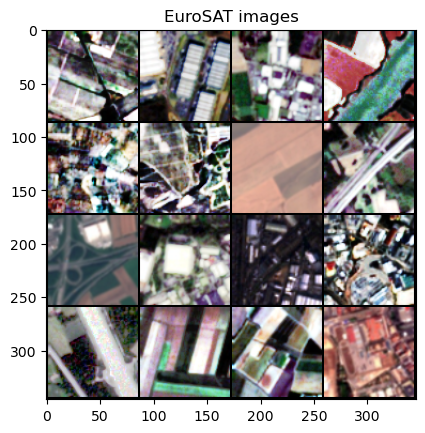

In [24]:
smallLoaders, _, _  = GetDataLoaders(data_dir, 16, SHUFFLE, num_workers=WORKERS)
euroSatInputs, euroSatclasses = next(iter(smallLoaders['train']))
out = torchvision.utils.make_grid(euroSatInputs, nrow=4, scale_each=False)
imshow(out, title='EuroSAT images')

In [25]:
print(euroSatclass_names)

['Pasture', 'Residential', 'SeaLake', 'Highway', 'PermanentCrop']


In [26]:
def eval(net, data_loader, criterion=nn.CrossEntropyLoss()):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    loss = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        outs = net(images)
        loss += criterion(outs, labels).item()
        _, predicted = torch.max(outs.data, 1)
        correct += (predicted == labels).sum().item()
        num_images += len(labels)
        print('testing -> batch: %d correct: %d num of images: %d' % (i_batch, correct, num_images) + '\r', end='')
    acc = correct / num_images
    loss /= len(data_loader)
    return acc, loss


# training function
def train(net, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    training_losses = []
    val_losses = []
    best_acc = 0.0
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        for epoch in range(num_epochs):
            net.train()
            correct = 0.0
            num_images = 0.0
            total_loss = 0.0

            for i_batch, (images, labels) in enumerate(train_loader):
                print(images.shape, labels.shape)
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                
                output_train = net(images)
                loss = criterion(output_train, labels)

                loss.backward()
                optimizer.step()
                _ , preds = torch.max(output_train, 1)   
                correct += torch.sum(preds == labels)
                num_images += len(labels)
                total_loss += loss.item()

            acc = correct / num_images
            acc_test, test_loss = eval(net, test_loader)
            average_loss = total_loss / len(train_loader)
            training_losses.append(average_loss)
            val_losses.append(test_loss)
            if acc_test > best_acc:
                best_acc = acc_test
                torch.save(net.state_dict(), best_model_params_path)
            print('\nepoch: %d, lr: %f, accuracy: %f, avg. loss: %f, test accuracy: %f test loss: %f\n' % (epoch, optimizer.param_groups[0]['lr'], acc, average_loss, acc_test, test_loss))

            scheduler.step()
            
        net.load_state_dict(torch.load(best_model_params_path))
    return net, training_losses, val_losses

In [27]:
from torchvision.models import resnet18, ResNet18_Weights
class Restnet18_WithoutTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        weights=ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights, progress=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
    
def get_model(model_path, num_of_classes, output_classes):
    model = Restnet18_WithoutTransformer(num_classes=num_of_classes)
    loaded_model = torch.load(os.path.join(os.getcwd(), model_path), map_location=device)
    model = Restnet18_WithoutTransformer(num_of_classes).to(device)
    model.load_state_dict(loaded_model)
    model.model.fc = nn.Linear(model.model.fc.in_features, output_classes).to(device)
    return model

In [28]:
episodes = 5
model = Restnet18_WithoutTransformer(num_of_classes).to(device)
for p in model.parameters():
    p.requires_grad = True
model.train()

data_dir = './data_eurosat/EuroSAT_RGB'
model_path = '..\\data\\models\\best_model_Resnet18_no_transform.pth'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=7, gamma=0.01)

total_test_loss = 0.0
total_test_acc = 0.0

for episode in range(episodes):
    print('--------------------------------------------------------------')
    print(f"Training Episode: {episode}")

    model = get_model(model_path, num_of_classes, classes_count).to(device)

    for param in model.parameters():
        param.requires_grad = True

    euroSatdataloaders, euroSatclass_names, euroSatdataset_sizes  = GetDataLoaders(data_dir, BATCH_SIZE, SHUFFLE, WORKERS, test_split, classes_count, samples_per_class)
    train_loader = euroSatdataloaders['train']
    test_loader = euroSatdataloaders['test']
    model, _, _ = train(net=model, train_loader=train_loader, test_loader=test_loader, num_epochs=NUM_EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

    acc_test, test_loss = eval(model, test_loader)
    total_test_loss += test_loss
    total_test_acc += acc_test
    print('\naccuracy on testing data: %f' % acc_test)
    print('loss on testing data: %f' % test_loss)

print("---------------------------------------------")   
print(f"Average Test Accuracy: {total_test_acc/episodes}")
print(f"Average Test Loss: {total_test_loss/episodes}")

--------------------------------------------------------------
Training Episode: 0
torch.Size([75, 3, 84, 84]) torch.Size([75])


IndexError: Target 6 is out of bounds.

In [ ]:
# from src.modelvis import visualize_models
import numpy as np
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_models(model, dataloaders, num_images, class_names):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_models(model, euroSatdataloaders, num_images, euroSatclass_names)